# Stepping in Time
### Finding numerical solutions to Differential Equations, part 1

There are very many situation where you want to take a particular starting point and then step a problem out in successive time steps. Any kind of animation would be using these methods, and many physics problems lend themselves to such solution, so stepping out a problem in time has many uses. Most of the time, whether you realized it or not, you are actually solving a differential equation, since $F=ma$, with $v = \frac{d x}{d t}$ and $a = \frac{d v}{d t}$ means that anything involving Newton's laws involves solving a differential equation.

In `scipy.integrate` there is a method that will allow you to solve Ordinary Differential Equations in a simple step. The notebook [A01_Ordinary_Differential_Equations]( https://github.com/mholtrop/Phys601/blob/master/Notebooks/A01_Ordinary_Differential_Equations.ipynb) shows you how to use this for a pendulum without the small angle approximation, and [A02_Double_Pendulum](https://github.com/mholtrop/Phys601/blob/master/Notebooks/A02_Double_Pendulum.ipynb) extends this to a double pendulum. I think it is a little unsatisfying though to just toss the problem to someone else's numerical method, so in this notebook we explore how you would solve these problems yourself. 

Why is it important to solve this on your own? Apart from being _educational_, you may need your own solution because the ones provided don't quite do what you need. In other situations, knowing what is "under the hood" will help you make better use of the existing methods.

## Euler's Method

The simplest way to solve a differential equation is with [Euler's method][euler], a solution that dates back to 1768. It is actually really simple to implement. For the mathematical proof, and the more mathematical treatment of the problem, I refer to the linked article. Here we will look at it practically.

In Euler's method we step through time in small steps $\Delta t$, and for each time step, you then calculate the new position of your object using the information you had from the _previous_ step. Since these are all _initial value problems_, you know all the information needed for the _first_ step. For constant velocity you would thus get:

$$
v=\frac{d x}{d t} \Rightarrow x_{i+1} = x_{i} + v_{i} \Delta t
$$
Note that this step involves integrating the original equation.

But what if there is acceleration? How do we deal with the second order derivative? It turns out that is better to break a second order derivative into a set of coupled equations with only first order derivatives. In the most general case, $F=ma$ has the force depend on time, position and possibly velocity, so we get:

$$
\begin{array}{lcl}
v(t)=\frac{d x}{d t} &\Rightarrow& x_{i+1} = x_{i} + v_{i} \Delta t \\
a(t)=\frac{d v}{d t}=\frac{F(x,v,t)}{m} &\Rightarrow& v_{i+1} = v_{i} + \frac{F(x,v,t)}{m} \Delta t
\end{array}
$$

The _general_ way to write these equations, using a function $f(t,y(t))$ is:

$$
y'(t) = f(t,y(t))   \Rightarrow y_{i+1} = y_{i} + f(t_i,y_i)\Delta t
$$

So for the first equation we have $f = v_i$, and the second $f = \frac{F}{m} $.

Most numerical methods of solving a differential equation are based on this same fundamental idea. To solve them you want to re-state the problem as a set of first order coupled differential equations, instead of higher order ones, which you can then evolve from the initial conditions ($t=0$ in our case) to the solution at some later point. 

As a simple example, we will solve the problem of throwing a baseball, but we add drag (air friction) to see a case where there is no immediate algebraic solution. Now, drag by itself leads to whole lot of complicated physics, see [Wikipedia on drag][drag], but here will simply take the [drag equation][drag_eqn] 

$$
F_D = \frac{1}{2}\rho v^2 C_D A
$$

with the [drag coefficient][drag_coeff] $C_D = 0.47$ for a sphere, and $\rho=1.225\ \mathrm{kg/m^3}$ for the [density of air][rho_air]. The [baseball][baseball] has a diameter of 74 mm, so $A = \pi(D/2)^2= 0.0043\ \mathrm{m^2}$, and a mass of 0.148 kg. 

[euler]: https://en.wikipedia.org/wiki/Euler_method
[drag]: https://en.wikipedia.org/wiki/Drag_(physics)
[drag_coeff]: https://en.wikipedia.org/wiki/Drag_coefficient
[drag_eqn]: https://en.wikipedia.org/wiki/Drag_equation
[baseball]: https://en.wikipedia.org/wiki/Baseball_(ball) 
[rho_air]: https://en.wikipedia.org/wiki/Density_of_air

The initial conditions are the angle with respect to the horizontal: $\theta$, and the velocity of the throw $v_0$. We need to solve the problem if both $x$ and $y$. There are many ways to implement this, but here I choose to express every vector simply as two variables, $x$ and $y$, $vx$, $vy$ etc. (An _alternate_ choice can be a larger _state vector_ where you encode all variables in one longer array. This leads to cleaner code, but can be more confusing.) 

The equations we then have are:

$$
\begin{array}{lcl}
x_{i+1} &=& x_{i} + vx_{i} \Delta t \\
vx_{i+1} &=& vx_{i} + \left(\frac{-F_{D_x}}{m}\right)\Delta_t \\
y_{i+1} &=& y_{i} + vy_{i} \Delta t \\
vy_{i+1} &=& vy_{i} + \left(\frac{-F_{D_y}}{m} - g\right) \Delta_t
\end{array}
$$

We now write a function that gives _step_ to the new values for $x$ and $v$ given the old values, the $\Delta t$, g, the mass, m, and $C=\frac{1}{2}\rho C_D A$. The reason for giving the _step_ and not the new value will become clear when we improve on the Euler method below. The new values found simply from the old values plus the step.

In [33]:
import numpy as np
g = 9.807
Cdrag = 0 # 0.5*1.225*0.47*0.0172
def Baseball_step(x,y,vx,vy,t,m,C):
    '''Function to calculate the next step for Euler equations of a baseball with drag.
       Note that t is not needed, so it is a dummy variable. It is there in case you want to modify
       the forces where they do depend on t.'''
    # v-squared:
    vsq = vx**2 + vy**2
    FD =  C*vsq
    FDx = FD*(vx/np.sqrt(vsq)) # Component of FD in the x direction.
    FDy = FD*(vy/np.sqrt(vsq)) # Component of FD in the y direction.
    dx_dt  = vx            # Update x and y
    dy_dt  = vy            
    dvx_dt =  ( -FDx/m)    # Update vx and vy using the forces.
    dvy_dt =  ( -FDx/m - g)
    return(dx_dt,dy_dt,dvx_dt,dvy_dt)  # Return the time derivatives. 

Now, a sanity check, to make sure the results of this equation make at least some sense. Throw the ball a fast 30 m/s (fastest pitch speeds are 44 m/s), at 45 degrees, so $vx = vy\approx 21.$m/s, and set the drag first to zero, then to standard strength, and time step 1 second (a big step!)

In [26]:
print(Baseball_step(0,0,21.,21.,0.,0.148,0))
print(Baseball_step(0,0,21.,21.,0.,0.148,Cdrag))

(21.0, 21.0, -0.0, -9.807)
(21.0, 21.0, -0.0, -9.807)


The first result looks fine, the second result,..., not so much, it leads to negative velocities in the next step. What is going on?

Well, it seems that the time step was way too large. Implicitly, the step was one second. This is a problem with these kinds of solutions, you need to set a reasonable time step. The definition of what is reasonable turns out to be quite complicated, since it turns out that in many situation the Euler method can go quite wrong. Details are found in the [Euler article][euler] in the section "Numerical Stability". If we try a smaller step, the result is more reasonable.

[euler]: https://en.wikipedia.org/wiki/Euler_method

In [27]:
(dx_dt,dy_dt,dvx_dt,dvy_dt)=Baseball_step(0,0,30.,30.,0,0.148,Cdrag)
dt=0.1
print(dx_dt*dt,dy_dt*dt,dvx_dt*dt,dvy_dt*dt)


3.0 3.0 -0.0 -0.9807000000000001


We can now write the code that does the actual stepping, and stores the results in arrays so they can be plotted. Here is the code without making use of the `scipy.integrate` methods. We can run the routine until the $y$ variable is less than zero, indicating the ball landed on the ground.

***NOTE:*** In the code below, I set the drag force to zero so I can compare with the _exact_ calculation.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.05
# Initial Values.
t = 0.
x = 0.
y = 1.5       # About the height of a player?
v = 30.      # That is a 100mph throw!
theta = 45.
mball = 0.148
g = 9.807

# Python remembers the drag from before.
# Cdrag =  0.5*1.225*0.47*0.0043

vx = v*np.cos(theta*np.pi/180.)
vy = v*np.sin(theta*np.pi/180.)

# Some lists to store the results into.
ta=[0]  # Store the time steps too.
xa=[x]
ya=[y]
vxa=[vx]
vya=[vy]

while y>0:
    # First calculate the steps.
    (dx_dt,dy_dt,dvx_dt,dvy_dt) = Baseball_step(x,y,vx,vy,0.,mball,Cdrag)
    x += dx_dt*dt        # Add the steps to the last values, so we go to i+1
    y += dy_dt*dt
    vx += dvx_dt*dt
    vy += dvy_dt*dt
    t += dt
    ta.append(t)
    xa.append(x)   # Store the values in our lists.
    ya.append(y)
    vxa.append(vx)
    vya.append(vy)
#
# Note to advanced Python programmers: You can see that if we were more clever programming this you
# could have something like  vals += Baseball_step(vals,dt,mball,Cdag) followed by  store.append(vals)
# So a lot fewer lines of code.
#
# Note that the last step is still in the t,x,y variables.
print("At t={:6.3f} s, the ball lands at y={:10.6f}m, x={:10.6f} m = {:10.6f} feet".format(t,y,x,3.28084*x))

At t= 4.450 s, the ball lands at y= -0.111775m, x= 94.398755 m = 309.707212 feet


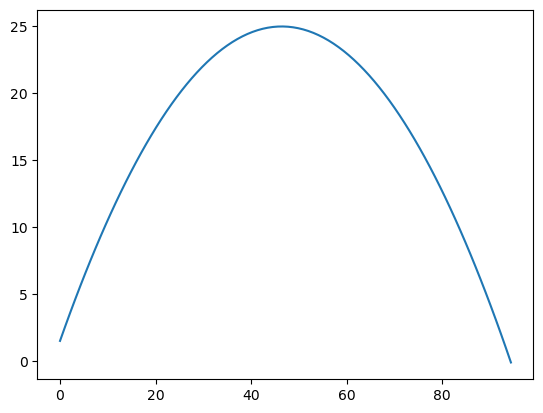

In [29]:
# Make a quick plot without decorations...
plt.plot(xa,ya)

You can now run this code a number of times to check if the result seems OK. First thing to do is reduce the step size $dt$ and look how the location where the ball lands changes. Once that seems stable, you know the $dt$ is reasonable. You also want to set the drag to zero. Now, if you want to check if you have the drag coefficient correct, this gets harder. On the "web", there are plenty of brags about far throws, and it is hard to find something reliable. Perhaps one answer was a 120 MPH throw with a distance of 445 feet. Is our calculation in the "ballpark"? (pun intended).

One thing to note if we want to compare the place where the ball _lands_, that this does not necessarily occur at a specific time step. In fact, it won't, so we need to do an interpolation or extrapolation (see the [Basic Calculus](https://github.com/mholtrop/Phys601/blob/master/Notebooks/04_Basic_Calculus.ipynb) notebook) at the end to get the actual $y=0$ result. For this reason you may want to step past the $y>0$ condition.

In [30]:
import scipy.interpolate as interpolate
print("Check last three points in x: ",xa[-3:])
print("Check last three points in y: ",ya[-3:])
time_from_y = interpolate.interp1d(ya[-5:],ta[-5:],kind="cubic") # MUST USE ONLY LAST FEW POINTS!
print("Time when ball lands (y=0) t=",time_from_y(0))
x_from_y = interpolate.interp1d(ya[-5:],xa[-5:],kind="cubic")
print("Actual location of ball in x when y=0, x=",x_from_y(0))

Check last three points in x:  [92.27743494484436, 93.33809511662417, 94.39875528840399]
Check last three points in y:  [2.0574674448444847, 0.985105116624307, -0.11177471159587071]
Time when ball lands (y=0) t= 4.444955448704658
Actual location of ball in x when y=0, x= 94.29174419553476


## Going Beyond Euler

In our case we could reduce the $\Delta t$ step size to some very small step and do hundreds of steps to get an accurate answer. It is not always possible, or desirable, to take so many steps. It turns out that there are far better ways to approximate an ODE instead of using Euler's method. The next more accurate method would be the [Midpoint Method](https://en.wikipedia.org/wiki/Midpoint_method) or modified Euler method. Instead of evaluating each step at the starting point, you evaluate at the mid-point. To do this you need to evaluate the function twice per step, instead of just once. Contrasting the two methods side by side, for a differential equation:

$$
y'(t) = f(t,y(t)),\ y(t_0) = y_0
$$
Then we would have, for step size of $\Delta t$:
$$
\begin{array}{llcl}
\mathrm{Euler:}& y_{i+1} &=& y_i + f(t_i,y_i) \Delta t \\
\mathrm{Mid-point:}& y_{i+1} &=& y_i + f(t_i + \frac{1}{2}\Delta t, y_i+ f(t_i,y_i)\frac{1}{2}\Delta t)\Delta t
\end{array}
$$

If you break apart the mid-point method in two steps:
$$
\begin{array}{lcl}
y_{temp} &=& y_i + f(t_i,y_t) \frac{1}{2}\Delta t \\
t_{temp} &=& t_i + \frac{1}{2}\Delta_t \\
y_{i+1} &=& y_i + f(t_{temp},y_{temp})\Delta_t
\end{array}
$$
So this is not _quite_ the same as just taking twice as many steps in the Euler's method. Note that the function $f(t,y(t))$ does not need modification between the two methods.

Below is the modified code that does the baseball throw with the midpoint method.

At t=    4.4 s, the ball lands at y=-0.0936649 m, x= 93.338095 m = 306.227356 feet


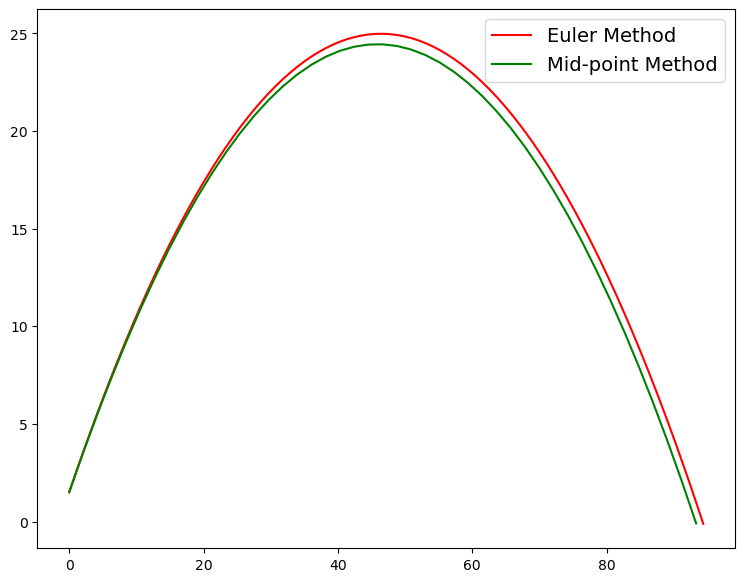

In [34]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.1
# Initial Values.
x0 = 0.
y0 = 1.5       # About the height of a player?
v0 = 30.      # That is a 100mph throw!
theta = 45.
mball = 0.148
g = 9.807

# Python remembers the Cdrag from before.
# Cdrag = 0.5*1.225*0.47*0.0043

# Some lists to store the results into.
t = 0
x = x0
y = y0
vx = v0*np.cos(theta*np.pi/180.)
vy = v0*np.sin(theta*np.pi/180.)

ta2=[t]
xa2=[x]
ya2=[y]
vxa2=[vx]
vya2=[vy]

while y>0:
    (dx_dt1,dy_dt1,dvx_dt1,dvy_dt1)  = Baseball_step(x,y,vx,vy,t,mball,Cdrag)
    (dx_dt2,dy_dt2,dvx_dt2,dvy_dt2)  = Baseball_step(x+dx_dt1*dt/2,y+dy_dt1*dt/2,vx+dvx_dt*dt/2,vy+dvy_dt*dt/2,
                                                     t,mball,Cdrag)
    t += dt
    x += dx_dt2*dt        # Add the steps to the last values, so we go to i+1
    y += dy_dt2*dt
    vx += dvx_dt2*dt
    vy += dvy_dt2*dt
    ta2.append(t)
    xa2.append(x)
    ya2.append(y)
    vxa2.append(vx)
    vya2.append(vy)

print("At t= {:6.3} s, the ball lands at y={:10.6} m, x={:10.6f} m = {:10.6f} feet".format(t,y,x,3.28084*x))
fig,(ax) = plt.subplots(1,1,figsize=(9,7))
ax.plot(xa,ya,label="Euler Method",color="red")
ax.plot(xa2[:100],ya2[:100],label="Mid-point Method",color="green")
ax.legend(fontsize=14)

How they compare?

We turned off friction, so we can compare with the exact values:

In [35]:
# Calculate exact without friction to compare. (Only works if you turned off friction!!!)
vx0 = v*np.cos(theta*np.pi/180.)
vy0 = v*np.sin(theta*np.pi/180.)
delta_t = (-vy0 - np.sqrt(vy0**2 + 2*g*y0))/(-g)
delta_x = vx0*delta_t
x_from_y   = interpolate.interp1d(ya[-5:],xa[-5:],kind="cubic")
x2_from_y2 = interpolate.interp1d(ya2[-5:],xa2[-5:],kind="cubic")
print("Exact     dx={:10.7f} at t={:10.7}".format(delta_x,delta_t))
x_euler = x_from_y(0)
print("Euler     dx={:10.7f} error= {:10.7f}".format(x_euler,delta_x - x_euler))
x_midpoint = x2_from_y2(0)
print("Mid-point dx={:10.7f} error= {:10.7f}".format(x_midpoint,delta_x - x_midpoint))
      # ,x,x-delta_x)

Exact     dx=93.2474365 at t=  4.395726
Euler     dx=94.2917442 error= -1.0443077
Mid-point dx=93.2474149 error=  0.0000216


So, with the mid-point method, if we call the function an equivalent number of times, we make a similar sized error, except in the other direction! This is why the Mid-point method isn't so useful. We could take the average, and do better. Instead of running everything twice and taking the average at the end, it is better to take the average at every step. This method would be Runga-Kutta, see below.

# Runga - Kutta
So what we saw was that we did better with a bit more work per step. How about doing even more intermediate steps? This can be accomplished with [The Runga-Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods). The standard (i.e. most used) is RK4, which has four weighted evaluations per step. The formula to use is:
$$
\begin{array}{lcl}
y_{i+1} &=& y_i + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right) \\
t_{i+1} &=& t_i + \Delta t \\
k1 &=& f(t_i,y_i) \Delta t \\
k2 &=& f(t_i+\frac{1}{2}\Delta t, y_i + \frac{1}{2}k_1 )\Delta t \\
k3 &=& f(t_i+\frac{1}{2}\Delta t, y_i + \frac{1}{2}k_2 )\Delta t \\
k4 &=& f(t_i+\Delta t, y_i + k_3 )\Delta t
\end{array}
$$

Note that our step function has no direct dependence of $t_i$, and includes the $\Delta t$ factor. 

Below, we implement this method:

The ball lands at x= 93.338095 m = 306.227356 feet


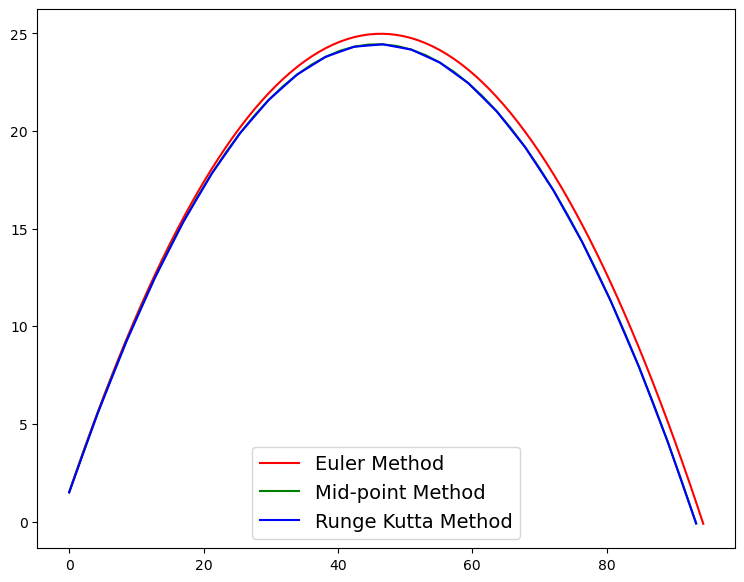

In [37]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.2
# Initial Values.
x0 = 0.
y0 = 1.5       # About the height of a player?
v0 = 30.      # That is a 100mph throw!
theta = 45.
mball = 0.148
g = 9.807

Cdrag = 0 #0.5*1.225*0.47*0.0043

# Some lists to store the results into.
x = x0
y = y0
vx = v0*np.cos(theta*np.pi/180.)
vy = v0*np.sin(theta*np.pi/180.)

xa3=[x]
ya3=[y]
vxa3=[vx]
vya3=[vy]

while y>0:
    (dx1_dt,dy1_dt,dvx1_dt,dvy1_dt)  = Baseball_step(x,y,vx,vy,t,mball,Cdrag)                          # k1
    (dx2_dt,dy2_dt,dvx2_dt,dvy2_dt)  = Baseball_step(x+dx1_dt*dt/2,y+dy1_dt*dt/2,vx+dvx1_dt*dt/2,vy+dvy1_dt*dt/2,
                                                     t,mball,Cdrag)    # k2
    (dx3_dt,dy3_dt,dvx3_dt,dvy3_dt)  = Baseball_step(x+dx2_dt*dt/2,y+dy2_dt*dt/2,vx+dvx2_dt*dt/2,vy+dvy2_dt*dt/2,
                                                     t,mball,Cdrag)    # k3
    (dx4_dt,dy4_dt,dvx4_dt,dvy4_dt)  = Baseball_step(x+dx3_dt*dt  ,y+dy3_dt*dt  ,vx+dvx3_dt*dt  ,vy+dvy3_dt*dt  ,
                                                     t,mball,Cdrag)    # k4

    x += (dx1_dt +2*dx2_dt +2*dx3_dt +dx4_dt )*dt/6        # Add the steps to the last values, so we go to i+1
    y += (dy1_dt +2*dy2_dt +2*dy3_dt +dy4_dt )*dt/6
    vx +=(dvx1_dt+2*dvx2_dt+2*dvx3_dt+dvx4_dt)*dt/6
    vy +=(dvy1_dt+2*dvy2_dt+2*dvy3_dt+dvy4_dt)*dt/6
    xa3.append(x)
    ya3.append(y)
    vxa3.append(vx)
    vya3.append(vy)

# Again, note that using Numpy we could program this more compactly, but I hope this way it is more clear
# what is happening in the code.
    
print("The ball lands at x={:10.6f} m = {:10.6f} feet".format(x,3.28084*x))
fig,(ax) = plt.subplots(1,1,figsize=(9,7))
ax.plot(xa,ya,label="Euler Method",color="red")
ax.plot(xa2,ya2,label="Mid-point Method",color="green")
ax.plot(xa3,ya3,label="Runge Kutta Method",color="blue")
ax.legend(fontsize=14)

In [38]:
# Calculate exact without friction to compare. (Only works if you turned off friction!!!)
vx0 = v*np.cos(theta*np.pi/180.)
vy0 = v*np.sin(theta*np.pi/180.)
delta_t = (-vy0 - np.sqrt(vy0**2 + 2*g*y0))/(-g)
delta_x = vx0*delta_t
x_from_y   = interpolate.interp1d(ya[-5:],xa[-5:],kind="cubic")
x2_from_y2 = interpolate.interp1d(ya2[-5:],xa2[-5:],kind="cubic")
x3_from_y3 = interpolate.interp1d(ya3[-5:],xa3[-5:],kind="cubic")
print("Exact       dx={:10.7f} at t={:10.7}".format(delta_x,delta_t))
x_euler = x_from_y(0)
print("Euler       dx={:10.7f} error= {:10.7f}".format(x_euler,delta_x - x_euler))
x_midpoint = x2_from_y2(0)
print("Mid-point   dx={:10.7f} error= {:10.7f}".format(x_midpoint,delta_x - x_midpoint))
x_rk4 = x3_from_y3(0)
print("Runge-Kutta dx={:10.7f} error= {:10.7f}".format(x_rk4,delta_x - x_rk4))


Exact       dx=93.2474365 at t=  4.395726
Euler       dx=94.2917442 error= -1.0443077
Mid-point   dx=93.2474149 error=  0.0000216
Runge-Kutta dx=93.2472354 error=  0.0002011


Both the mid-point and Runge-Kutta methods do very well. It turns out that *for this particular problem* the mid-point method does as well as Runga-Kutta (or slightly better, depending on the setting for the drag), but this is not the case for all types or problems. There are a lot of problems where RK4 is the best you can do. 

The way to further improve the calculation would be by varying the step size $\Delta t$, to be smaller in regions where the trajectory cureves more and larger where the trajectory is relatively straight. That gets more complicated to implement, but fortunately there are algorithms where this is already done for us.

## Using the odeint function

We wouldn't be using Python if we had to do all this by hand. The code above would easily translate to any other language, i.e. Fortran. If we use Python, we can use the `scipy.integrate.odeint` method.

One difference with that method is that we have to give it the total number of steps. We cannot say: "Stop when y<0". To accomplish this, you would need to guess the number of steps, and then check if your guess was correct.

We also need to change the function _signature_ a little, so that odeint understands what we are calling it with. The new function and the method of solving the ODE is implemented below.

The last few y values are: [ 7.89681374  4.09771443 -0.09366488 -4.6773242  -9.65326351]
So we want: y= -0.09366488368338821
At t=  4.400 s, the ball lands at y=  -0.093665 m, x= 93.338095 m = 306.227356 feet


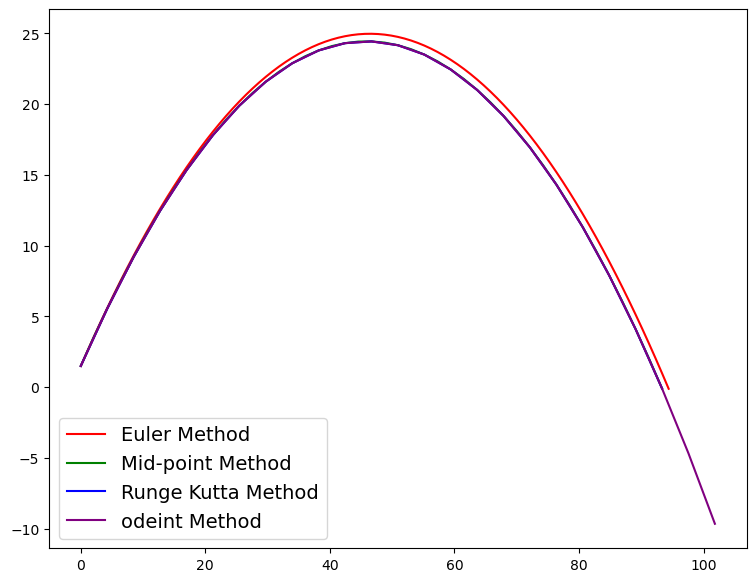

In [54]:
import scipy.integrate as integrate

def Baseball_step2(invars,t,m,C):
    x,y,vx,vy = invars
    
    '''Function to calculate the next step for Euler equations of a baseball with drag.
       Note that t is not needed, so it is a dummy variable, useful for odeint. '''
    # v-squared:
    vsq = vx**2 + vy**2
    FD =  C*vsq
    FDx = FD*(vx/np.sqrt(vsq)) # Component of FD in the x direction.
    FDy = FD*(vy/np.sqrt(vsq)) # Component of FD in the y direction.
    dx_dt  = vx            # Update x and y
    dy_dt  = vy            
    dvx_dt =  ( -FDx/m)    # Update vx and vy using the forces.
    dvy_dt =  ( -FDx/m - g)
    return([dx_dt,dy_dt,dvx_dt,dvy_dt])

# Note: If you turn on the drag, 5 seconds is too long, and you would need to go to only 4 seconds.
t = np.arange(0.,5.,0.2)  # Try 5. seconds, 0.2 size steps

initial_state=[x0,y0,vx0,vy0]

sol = integrate.odeint(Baseball_step2,initial_state,t,args=(mball,Cdrag))
print("The last few y values are:",sol[-5:,1])
print("So we want: y=",sol[-3,1])
print("At t= {:6.3f} s, the ball lands at y= {:10.6f} m, x={:10.6f} m = {:10.6f} feet".format(t[-3],sol[-3,1],sol[-3,0],3.28084*sol[-3,0]))
fig,(ax) = plt.subplots(1,1,figsize=(9,7))
ax.plot(xa,ya,label="Euler Method",color="red")
ax.plot(xa2,ya2,label="Mid-point Method",color="green")
ax.plot(xa3,ya3,label="Runge Kutta Method",color="blue")
ax.plot(sol[:,0],sol[:,1],label="odeint Method",color="purple")
ax.legend(fontsize=14)

In [55]:
# Calculate exact without friction to compare. (Only works if you turned off friction!!!)
vx0 = v*np.cos(theta*np.pi/180.)
vy0 = v*np.sin(theta*np.pi/180.)
delta_t = (-vy0 - np.sqrt(vy0**2 + 2*g*y0))/(-g)
delta_x = vx0*delta_t
x_from_y   = interpolate.interp1d(ya[-10:],xa[-10:],kind="cubic")
x2_from_y2 = interpolate.interp1d(ya2[-10:],xa2[-10:],kind="cubic")
x3_from_y3 = interpolate.interp1d(ya3[-10:],xa3[-10:],kind="cubic")
x4_from_y4 = interpolate.interp1d(sol[-10:,1],sol[-10:,0],kind="cubic")
print("Exact       dx={:10.7f} at t={:10.7}".format(delta_x,delta_t))
x_euler = x_from_y(0)
print("Euler       dx={:10.7f} error= {:10.7f}".format(x_euler,delta_x - x_euler))
x_midpoint = x2_from_y2(0)
print("Mid-point   dx={:10.7f} error= {:10.7f}".format(x_midpoint,delta_x - x_midpoint))
x_rk4 = x3_from_y3(0)
print("Runge-Kutta dx={:10.7f} error= {:10.7f}".format(x_rk4,delta_x - x_rk4))
x_odeint = x4_from_y4(0)
print("odeint      dx={:10.7f} error= {:10.7f}".format(x_odeint,delta_x - x_odeint))

Exact       dx=93.2474365 at t=  4.395726
Euler       dx=94.2917439 error= -1.0443074
Mid-point   dx=93.2474121 error=  0.0000245
Runge-Kutta dx=93.2471800 error=  0.0002565
odeint      dx=93.2474307 error=  0.0000058


The `scipy.integrate.odeint()` performs best. The deeper reason for this is that it will take multiple steps between the steps asked for in order to keep a higher accuracy. The comparison is thus not quite a 1 to 1 comparison, because `odeint()` will call our function more often than our RK4 implementation. You can try for yourself to decrease the RK4 stepsize and get a similar or better accuracy.